In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import json
import numpy as np

In [2]:
# RESULTS_ROOT = './results/models'
RESULTS_ROOT = '/data/common/geospatial_fm/models'
model_name = "LESSVIT"

In [3]:
def clear_ckpts(dataset):
    import shutil
    cnt = 0
    dataset_dir = f"{RESULTS_ROOT}/{dataset}"
    for dir in os.listdir(dataset_dir):
        if os.path.exists(os.path.join(dataset_dir, dir, "test_results.json")):
            # remove all ckpts dirs
            for sub_dir in os.listdir(os.path.join(dataset_dir, dir)):
                if "checkpoint" in sub_dir:
                    shutil.rmtree(os.path.join(dataset_dir, dir, sub_dir))
                    cnt += 1
    print(f"Cleared {cnt} ckpts for {dataset}")

In [4]:
def collect_results(model_name, dataset, metric_name, filter_key:dict=None):
    dataset_dir = f"{RESULTS_ROOT}/{dataset}"
    
    df_all = []
    for dir in os.listdir(dataset_dir):
        if model_name not in dir:
            continue
        target_file = os.path.join(dataset_dir, dir, "test_results.json")
        try:
            with open(target_file, 'r') as f:
                log = json.load(f)
        except:
            continue
        lp = "lp" in dir
        modal = "optical"
        if "radar" in dir:
            modal = "radar"
        elif "multi" in dir:
            modal = "multi"
        # replace the first - with _
        if "LESSVIT-S" in dir: dir = dir.replace("LESSVIT-S", "LESSVIT_s")
        model_config = dir.split("_")
            
        moe_idx = next((i for i, x in enumerate(model_config) if x.startswith("moe")), None)
        if moe_idx is not None:
            log['moe'] = int(model_config.pop(moe_idx).replace("moe", ""))
        else:
            log['moe'] = 0
            
        topk_idx = next((i for i, x in enumerate(model_config) if x.startswith("topk")), None)
        if topk_idx is not None:
            log['topk'] = int(model_config.pop(topk_idx).replace("topk", ""))
        else:
            log['topk'] = 3
        
        # find the config start with ckpt
        ckpt_idx = next((i for i, x in enumerate(model_config) if x.startswith("ckpt")), None)
        if ckpt_idx is not None:
            log['ckpt'] = int(model_config.pop(ckpt_idx).replace("ckpt", ""))
        else:
            log['ckpt'] = 24600
        
        try:
            model_config = model_config[:7]
            _, embed_dims, depth, rank, _, lr, scale = tuple(model_config) 
            log['embed_dims'] = int(embed_dims.replace("s", "")) # TODO: choose between s and b
            log['depth'] = int(depth.replace("d", ""))
            log['lr'] = float(lr.replace("lr", ""))
            log['scale'] = float(scale.replace("scale", ""))
            log['lp'] = lp
            log['modal'] = modal
            log['rank'] = int(rank.replace("r", ""))
        except:
            model_config = model_config[:6]
            _, embed_dims, depth, _, lr, scale = tuple(model_config) 
        
            log['embed_dims'] = int(embed_dims.replace("b", ""))
            log['depth'] = int(depth.replace("d", ""))
            log['lr'] = float(lr.replace("lr", ""))
            log['scale'] = float(scale.replace("scale", ""))
            log['lp'] = lp
            log['modal'] = modal
            log['rank'] = 1
        df_all.append(log)
            
    df_all = pd.DataFrame(df_all)
    if filter_key is not None:
        for key, value in filter_key.items():
            df_all = df_all.loc[df_all[key] == value]
    df_all = df_all.reset_index()
    df_all_stat = df_all.groupby(['embed_dims', 'depth', 'scale', 'moe', 'lp', 'modal', 'rank']).apply(lambda x: x.loc[x[metric_name].idxmax()])
    df_all_stat = df_all_stat.drop(columns=['embed_dims', 'depth', 'scale', 'moe', 'lp', 'modal', 'rank'])
    df_all_stat = df_all_stat.reset_index().drop(columns=['index'])
    df_all_stat.sort_values(by=[metric_name], ascending=False)
    return df_all, df_all_stat

## Classification

In [5]:
dataset = 'eurosat'
metric_name = 'eval_accuracy'

df_all, df_all_stat = collect_results(model_name, dataset, metric_name, filter_key={"lp": False, "scale": 2.0, "ckpt": 24600})
df_all_stat

,embed_dims,depth,scale,moe,lp,modal,rank,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,topk,ckpt,lr
0,2,4,2.0,0,False,optical,1,19.692913,0.976111,0.101326,100.0617,53.967,1.689,3,24600,0.00030
1,2,4,2.0,0,False,optical,2,19.692913,0.975185,0.109551,58.1708,92.830,2.905,3,24600,0.00030
2,2,4,2.0,0,False,optical,4,19.692913,0.975185,0.100763,45.2835,119.249,3.732,3,24600,0.00008
3,2,4,2.0,0,False,optical,8,19.692913,0.974444,0.105448,93.9326,57.488,1.799,3,24600,0.00010


<Axes: xlabel='rank', ylabel='eval_accuracy'>

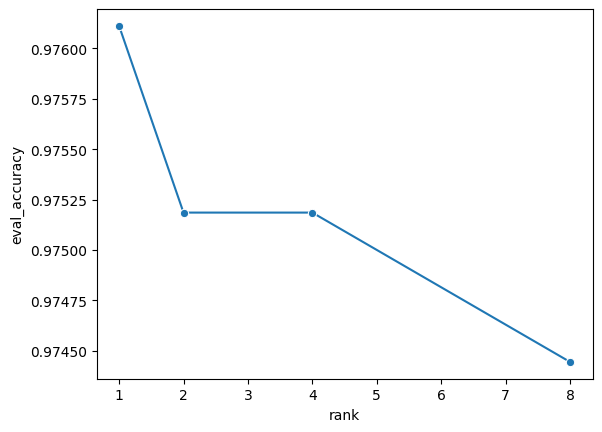

In [6]:
sns.lineplot(data=df_all_stat, x="rank", y="eval_accuracy", marker="o")

<Axes: xlabel='lr', ylabel='eval_accuracy'>

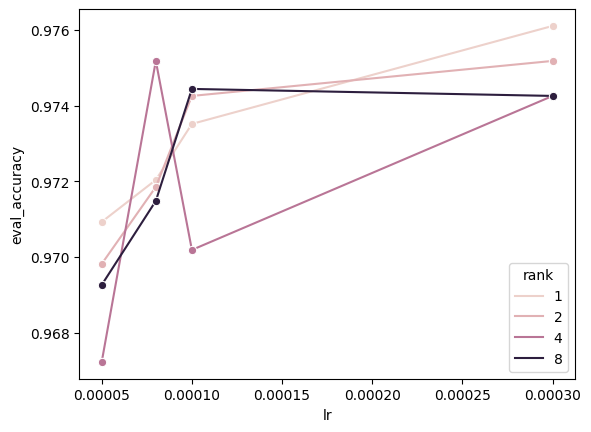

In [7]:
sns.lineplot(data=df_all, x="lr", y="eval_accuracy", hue="rank", marker="o")

In [7]:
dataset = 'bigearthnet'
metric_name = 'eval_micro_mAP'

# df_all, df_all_stat = collect_results(model_name, dataset, metric_name, filter_key={"lp": False, "ckpt": 24600, "modal": "optical"})
df_all, df_all_stat = collect_results("LESSVIT-S", dataset, metric_name, filter_key={"lp": False, "ckpt": 24600, "modal": "optical"})
df_all_stat

,embed_dims,depth,scale,moe,lp,modal,rank,epoch,eval_loss,eval_micro_mAP,eval_runtime,eval_samples_per_second,eval_steps_per_second,topk,ckpt,lr
0,2,4,1.0,0,False,optical,1,10.0,0.166532,0.854625,663.2798,189.763,5.931,3,24600,0.0001
1,2,4,1.0,0,False,optical,2,10.0,0.166419,0.854791,815.8200,154.282,4.822,3,24600,0.0001
2,2,4,1.0,0,False,optical,4,10.0,0.165891,0.855399,1572.9228,80.020,2.501,3,24600,0.0001
3,2,4,1.0,0,False,optical,8,10.0,0.166218,0.855181,661.1355,190.379,5.950,3,24600,0.0001


In [8]:
_, df_moe_optical = collect_results("LESSVIT_b", dataset, metric_name, filter_key={"lp": True, "ckpt": 73800, "modal": "optical"})
_, df_moe_multi = collect_results("LESSVIT_b", dataset, metric_name, filter_key={"lp": True, "ckpt": 73800, "modal": "multi"})
_, df_rank = collect_results("LESSVIT-S", dataset, metric_name, filter_key={"lp": False, "ckpt": 24600, "modal": "optical"})
# for all the eval_micro_mAP, times 100 and round to 2 decimal place
df_moe_optical["eval_micro_mAP"] = np.round(df_moe_optical["eval_micro_mAP"] * 100, 2)
df_moe_multi["eval_micro_mAP"] = np.round(df_moe_multi["eval_micro_mAP"] * 100, 2)
df_rank["eval_micro_mAP"] = np.round(df_rank["eval_micro_mAP"] * 100, 2)
df_rank.sort_values(by="rank", ascending=False, inplace=True)
df_rank['n_params'] = [27.3, 23.7, 21.9, 21.0]

# put df_moe_optical and df_moe_multi in the same plot
df_moe_optical["Modal"] = "Optical"
df_moe_multi["Modal"] = "Optical+Radar"
df_moe = pd.concat([df_moe_optical, df_moe_multi])

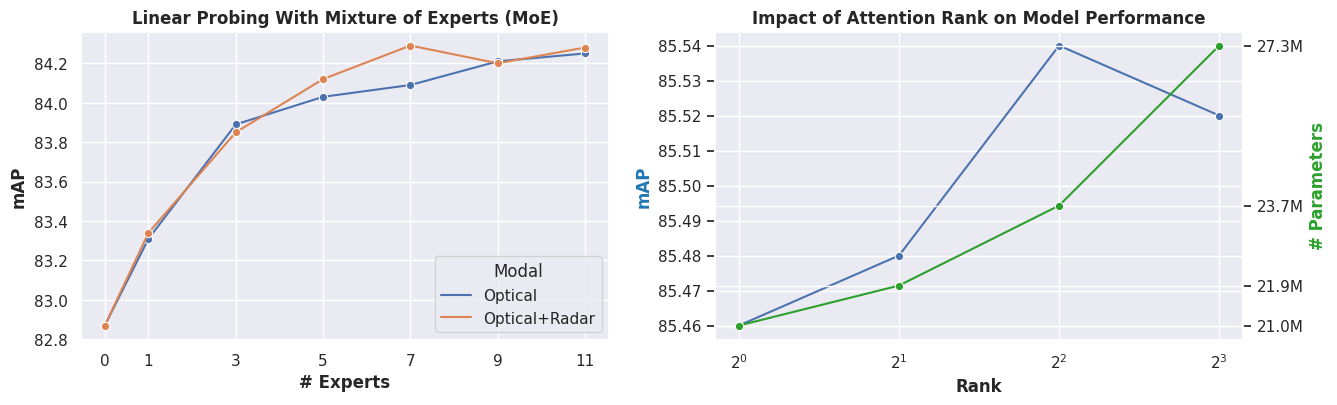

In [11]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.lineplot(data=df_moe, x="moe", y="eval_micro_mAP", marker="o", ax=ax[0], hue="Modal")
ax[0].set_xticks(df_moe["moe"].unique())
ax[0].set_xticklabels(df_moe["moe"].unique())
# put the legend in the right side of the plot
ax[0].legend(loc="lower right", title="Modal")
# change the y label to mAP
ax[0].set_ylabel("mAP", fontweight="bold")
# change the x label to # Experts
ax[0].set_xlabel("# Experts", fontweight="bold")
ax[0].set_title("Linear Probing With Mixture of Experts (MoE)", fontweight="bold")

sns.lineplot(data=df_rank, x="rank", y="eval_micro_mAP", marker="o", ax=ax[1])
ax[1].set_ylabel("mAP", fontweight="bold", color="tab:blue")
ax[1].set_xlabel("Rank", fontweight="bold")
ax[1].set_xticks(df_rank["rank"].unique())
ax[1].set_xscale("log", base=2)
# ax[1].set_xticklabels(["1", "2", "4", "8"])
# ax[1].set_title("Linear Probing With Low-Rank Attention", fontweight="bold")

ax_3 = ax[1].twinx()
sns.lineplot(data=df_rank, x="rank", y="n_params", marker="o", ax=ax_3, color="tab:green")
ax_3.set_ylabel("# Parameters", fontweight="bold", color="tab:green")
# add M to every y tick label
# set y ticks to unique values
ax_3.set_yticks(df_rank["n_params"].unique())
ax_3.set_yticklabels([f"{y}M" for y in ax_3.get_yticks()])
ax[1].set_title("Impact of Attention Rank on Model Performance", fontweight="bold")
plt.show()
# save as pdf
# plt.savefig("rank_mAP.pdf", bbox_inches="tight", dpi=300, pad_inches=0)

In [7]:
# df_plot_stat = df_all_stat.copy()
# df_plot_stat.rename(columns={"modal": "Modal"}, inplace=True)
# df_plot_stat.rename(columns={"moe": "# Experts"}, inplace=True)
# df_plot_stat.rename(columns={"eval_micro_mAP": "mAP"}, inplace=True)
# # change multi to Optical+Radar
# df_plot_stat.loc[df_plot_stat["Modal"] == "multi", "Modal"] = "Optical+Radar"
# df_plot_stat.loc[df_plot_stat["Modal"] == "optical", "Modal"] = "Optical"

# # drop rows with # Experts = 0
# # df_plot_stat = df_plot_stat[df_plot_stat["# Experts"] != 0]
# # all the map x 100
# df_plot_stat["mAP"] = df_plot_stat["mAP"] * 100

# # set the figure size
# plt.figure(figsize=(10, 4))
# sns.set_theme()

# # change modal to Modal
# sns.lineplot(data=df_plot_stat, x="# Experts", y="mAP", hue="Modal", marker="o")
# # change x tick labels
# plt.xticks(df_plot_stat["# Experts"].unique(), df_plot_stat["# Experts"].unique())
# plt.xlabel("# Experts", fontweight="bold")
# plt.ylabel("mAP", fontweight="bold")
# # bold the title
# plt.title("Linear Probing With Mixture of Experts (MoE)", fontweight="bold")
# # # add an horizontal line at y = 82.87, the color is the same as Optical+Radar
# plt.show()
# # save as pdf
# # plt.savefig("moe_mAP.pdf", bbox_inches="tight", dpi=300, pad_inches=0)

In [8]:
dataset = 'so2sat'
metric_name = 'eval_accuracy'

df_all, df_all_stat = collect_results(model_name, dataset, metric_name, filter_key={"lp": False, "scale": 4.0, "ckpt": 94200})
df_all_stat

FileNotFoundError: [Errno 2] No such file or directory: './results/models/so2sat'

## Segmentation

In [48]:
dataset = 'segmunich'
metric_name = 'eval_IoU'

df_all, df_all_stat = collect_results(model_name, dataset, metric_name, filter_key={"ckpt": 94200})
df_all_stat

5,embed_dims,depth,scale,moe,lp,modal,rank,epoch,eval_IoU,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,topk,ckpt,lr
0,2,8,1.0,0,False,optical,1,9.954914,0.422907,0.687459,499.0044,19.731,0.617,3,94200,0.0003


In [49]:
dataset = 'dfc2020'
metric_name = 'eval_IoU'

df_all, df_all_stat = collect_results(model_name, dataset, metric_name, filter_key={"ckpt": 24600})
df_all_stat

,embed_dims,depth,scale,moe,lp,modal,rank,epoch,eval_IoU,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,topk,ckpt,lr
0,2,4,1.0,0,False,optical,2,9.984592,0.386357,0.864857,210.5819,42.140,1.320,3,24600,0.00003
1,2,4,1.0,0,False,optical,3,9.984592,0.390126,0.922564,203.5464,43.597,1.366,3,24600,0.00003
2,2,4,1.0,0,False,optical,5,9.984592,0.424618,0.798978,198.0917,44.797,1.403,3,24600,0.00003
3,2,4,1.0,0,False,optical,8,9.984592,0.473565,0.638685,197.6440,44.899,1.407,3,24600,0.00003


In [50]:
dataset = 'marida'
metric_name = 'eval_IoU'

df_all, df_all_stat = collect_results(model_name, dataset, metric_name, filter_key={"ckpt": 94200})
df_all_stat

7,embed_dims,depth,scale,moe,lp,modal,rank,epoch,eval_IoU,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,topk,ckpt,lr
0,2,8,1.0,0,False,optical,1,9.795918,0.556429,0.698661,134.5889,45.94,1.441,3,94200,0.00008


In [31]:
dataset = 'landsat'
metric_name = 'eval_IoU'

df_all, df_all_stat = collect_results(model_name, dataset, metric_name, filter_key={"ckpt": 73800})
df_all_stat

KeyError: 'ckpt'

In [13]:
df_all

,index,epoch,eval_IoU,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,moe,topk,ckpt,embed_dims,depth,lr,scale,lp,modal
0,0,9.989339,0.232021,1.058459,155.5005,20.624,0.650,0,3,73800,2,4,0.00050,1.0,False,optical
1,1,9.989339,0.240693,1.038104,160.0591,20.036,0.631,0,3,73800,2,4,0.00010,1.0,False,optical
2,2,9.989339,0.113345,1.672956,180.3185,17.785,0.560,0,3,73800,2,4,0.00080,1.0,False,optical
3,3,9.836713,0.244034,1.017071,152.9754,20.964,0.660,0,3,73800,2,4,0.00030,1.0,False,optical
4,4,9.989339,0.237204,1.056266,195.0529,16.442,0.518,0,3,73800,2,4,0.00008,1.0,False,optical
5,5,9.836713,0.228334,1.091147,218.4693,14.679,0.462,0,3,73800,2,4,0.00005,1.0,False,optical
6,6,9.989339,0.229531,1.086186,164.8778,19.451,0.613,0,3,73800,2,4,0.00005,1.0,False,optical
7,7,9.836713,0.209672,1.146307,147.1823,21.789,0.686,0,3,73800,2,4,0.00003,1.0,False,optical
8,8,9.836713,0.234644,1.049432,188.5231,17.011,0.536,0,3,73800,2,4,0.00050,1.0,False,optical
9,9,9.989339,0.213849,1.132244,165.4537,19.383,0.610,0,3,73800,2,4,0.00003,1.0,False,optical


In [13]:
# clear_ckpts("bigearthnet")
# clear_ckpts("segmunich") 
clear_ckpts("dfc2020")
clear_ckpts("eurosat")
# clear_ckpts("marida")
# clear_ckpts("so2sat")
# clear_ckpts("landsat")

Cleared 0 ckpts for dfc2020
Cleared 8 ckpts for eurosat


In [29]:
df_all_stat

,embed_dims,depth,scale,moe,lp,modal,rank,epoch,eval_loss,eval_micro_mAP,eval_runtime,eval_samples_per_second,eval_steps_per_second,topk,ckpt,lr
0,2,4,1.0,0,False,optical,1,10.0,0.164229,0.858080,69.3816,178.318,5.578,3,24600,0.00010
1,2,4,1.0,0,False,optical,2,10.0,0.164699,0.857314,76.8375,161.015,5.037,3,24600,0.00010
2,2,4,1.0,0,False,optical,4,10.0,0.164517,0.857123,68.4972,180.621,5.650,3,24600,0.00008
3,2,4,1.0,0,False,optical,8,10.0,0.164211,0.857670,67.0728,184.456,5.770,3,24600,0.00010


In [32]:
def to_scientific_clean(num):
    return '{:1.0e}'.format(num).replace('e-0', 'e-').replace('e+0', 'e')

In [52]:
# extract desired file names from the table
train_dfs = []
eval_dfs = []
for _, row in df_all_stat.iterrows():
    embed_dim, depth, rank, lr = row["embed_dims"], row["depth"], row["rank"], row["lr"]
    file_name = f"LESSVIT-S{embed_dim}_d{depth}_r{rank}_bigearthnet_lr{to_scientific_clean(lr)}_scale{int(row['scale'])}"
    # open the trainer_state.json file
    file_path = f"/data-4/common/geospatial_fm/models/bigearthnet/{file_name}/trainer_state.json"
    with open(file_path, "r") as f:
        trainer_state = json.load(f)
    # print the best eval_micro_mAP
    log = trainer_state["log_history"]
    # log = [x for x in log if int(x["epoch"]) == x["epoch"]]
    train_log = [x for x in log if "loss" in x.keys()]
    eval_log = [x for x in log if "eval_loss" in x.keys()][:10]
    # conver the two lists of dicts into two dataframes
    train_df = pd.DataFrame(train_log)
    eval_df = pd.DataFrame(eval_log)
    train_df["rank"] = rank
    eval_df["rank"] = rank
    train_dfs.append(train_df)
    eval_dfs.append(eval_df)
train_df = pd.concat(train_dfs)
eval_df = pd.concat(eval_dfs)


<Axes: xlabel='epoch', ylabel='loss'>

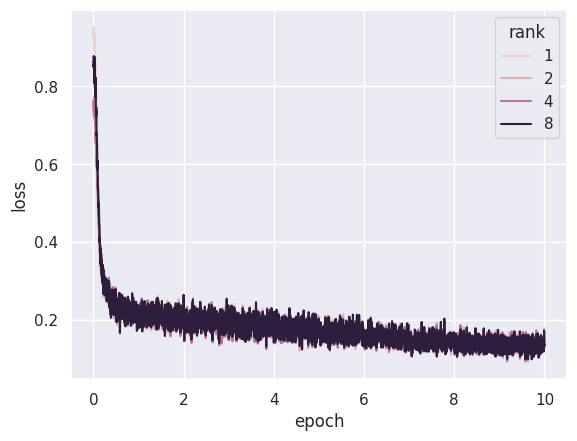

In [54]:
sns.lineplot(data=train_df, x="epoch", y="loss", hue="rank")

In [47]:
eval_df

,epoch,eval_loss,eval_micro_mAP,eval_runtime,eval_samples_per_second,eval_steps_per_second,step
0,1.0,0.214767,0.762183,85.0207,145.518,4.552,422
1,2.0,0.194002,0.803158,67.3809,183.613,5.743,844
2,3.0,0.190624,0.809426,66.9016,184.928,5.785,1266
3,4.0,0.181358,0.826049,67.1930,184.126,5.760,1688
4,5.0,0.178536,0.830618,64.6505,191.367,5.986,2110
5,6.0,0.171785,0.843031,65.4252,189.101,5.915,2532
6,7.0,0.166609,0.852412,66.9713,184.736,5.779,2954
7,8.0,0.165444,0.855468,75.0836,164.776,5.154,3376
8,9.0,0.164229,0.858080,68.3519,181.004,5.662,3798
9,10.0,0.164411,0.857951,70.6272,175.173,5.479,4220
